# 1. Data Import and Analysis

In [1]:
%pip install --quiet gensim nltk optuna seaborn torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pickle
import gensim
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [3]:
os.chdir("../../..")

In [4]:
from src.utils.preprocessing import preprocess_text
from src.utils.visualization import plot_sentiment_distribution

In [5]:
df = pd.read_csv(
    'dataset/processed/combined_sentiment_dataset.csv', 
    encoding='utf-8'
)
df.head()

,Sentences,Sentiment
0,पुन निर्वाचन गरे यस्तै हुने हो निर्वाचन कति गर...,0
1,क्या अचम्मकाे नगरपालिका डाेजरम्यान बालेनकाे,0
2,प्युठान नगरपालिका नेपाल स्वयंसेवक राष्ट्रिय सम...,0
3,कपिलवस्तुको शिवराज नगरपालिका का बासिन्दाले पाए...,0
4,कपिलवस्तुको शिवराज नगरपालिका का बासिन्दाले वर्...,0


In [6]:
df.shape

(40708, 2)

In [7]:
labels_dict = {
    0: 'Neutral', 
    1: 'Positive', 
    2: 'Negative'
}

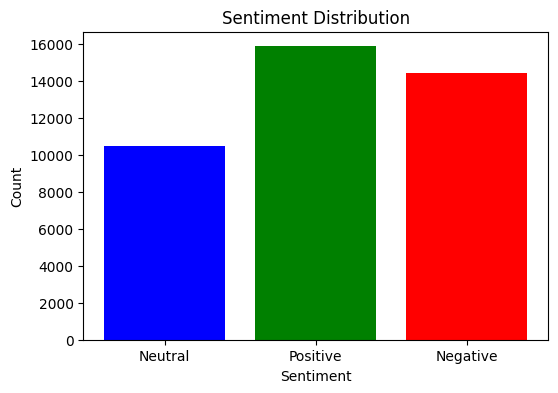

In [8]:
plot_sentiment_distribution(
    df, 
    'Sentiment Distribution', 
    labels_dict
)

### Length of the reviews

In [9]:
def print_len(data):
    total_len = 0
    pos_len = 0
    neg_len = 0
    neu_len = 0
    for index, row in data.iterrows():
        l = len(row['Sentences'].split(' '))
        total_len += l
        if row['Sentiment'] == 0:
            pos_len += l
        else:
            neg_len += l

    print('Average length of Sentence : ' +
          str(total_len/len(data['Sentences'])))
    print('Average length of positive Sentence : ' +
          str(pos_len/df['Sentiment'].value_counts()[1]))
    print('Average length of negative Sentence : ' +
          str(neg_len/df['Sentiment'].value_counts()[2]))
    print('Average length of negative Sentence : ' +
          str(neu_len/df['Sentiment'].value_counts()[0]))


print_len(df)

Average length of Sentence : 16.050849955782645
Average length of positive Sentence : 9.55924828151605
Average length of negative Sentence : 34.86535121239491
Average length of negative Sentence : 0.0


### Missing and Duplicated values

In [10]:
df.isna().sum()

Sentences    0
Sentiment    0
dtype: int64

In [11]:
df.duplicated().sum()

321

In [12]:
df = df.drop_duplicates()

# 3. Text Understanding

In [13]:
from collections import Counter

# Extract sentences based on sentiment
neutral_reviews = df[df['Sentiment'] == 0]['Sentences']
positive_reviews = df[df['Sentiment'] == 1]['Sentences']
negative_reviews = df[df['Sentiment'] == 2]['Sentences']

# Combine reviews of each sentiment into a single string
positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)
neutral_text = ' '.join(neutral_reviews)

# Calculate word frequencies for each sentiment
positive_word_freq = Counter(positive_text.split(' '))
negative_word_freq = Counter(negative_text.split(' '))
neutral_word_freq = Counter(neutral_text.split(' '))

# Create a dictionary to store the frequency differences
word_diff = {}

# Calculate the frequency difference for each word across all three sentiments
all_words = set(positive_word_freq.keys()).union(set(negative_word_freq.keys())).union(set(neutral_word_freq.keys()))

for word in all_words:
    pos_freq = positive_word_freq.get(word, 0)
    neg_freq = negative_word_freq.get(word, 0)
    neu_freq = neutral_word_freq.get(word, 0)
    # We calculate the difference based on each sentiment's word frequency
    word_diff[word] = abs(pos_freq - neg_freq) + abs(neg_freq - neu_freq) + abs(pos_freq - neu_freq)

# Separate positive, negative, and neutral words based on frequency differences
positive_words_diff = {}
negative_words_diff = {}
neutral_words_diff = {}

# Classify words based on where they are most frequent
for word, diff in word_diff.items():
    if positive_word_freq.get(word, 0) > max(negative_word_freq.get(word, 0), neutral_word_freq.get(word, 0)):
        positive_words_diff[word] = diff
    elif negative_word_freq.get(word, 0) > max(positive_word_freq.get(word, 0), neutral_word_freq.get(word, 0)):
        negative_words_diff[word] = diff
    elif neutral_word_freq.get(word, 0) > max(positive_word_freq.get(word, 0), negative_word_freq.get(word, 0)):
        neutral_words_diff[word] = diff

# Sort the words by frequency difference (descending)
sorted_positive_words = sorted(positive_words_diff.items(), key=lambda x: x[1], reverse=True)
sorted_negative_words = sorted(negative_words_diff.items(), key=lambda x: x[1], reverse=True)
sorted_neutral_words = sorted(neutral_words_diff.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 words for positive, negative, and neutral categories
print("Top 20 Positive Words:")
for word, diff in sorted_positive_words[:20]:
    print(word)

print("--------\nTop 20 Negative Words:")
for word, diff in sorted_negative_words[:20]:
    print(word)

print("---------\nTop 20 Neutral Words:")
for word, diff in sorted_neutral_words[:20]:
    print(word)


Top 20 Positive Words:
कोभिड
लागि
तथा
गर्न
गरेको
गर्ने
स्वास्थ्य
सरकारले
परीक्षण
सहयोग
रोकथाम
खोप
नेपाल
उपचार
शुभकामना
विरुद्धको
नियन्त्रण
हुने
विरुद्ध
गरिएको
--------
Top 20 Negative Words:
कोरोना
मृत्यु
भाइरस
भएको
संक्रमण
संख्या
पुष्टि
संक्रमित
हजार
जनामा
कारण
थप
एक
नेपालमा
जना
का
लाख
छन्
संक्रमितको
पुगेको
---------
Top 20 Neutral Words:
एमाले
कांग्रेस
मेयर
मत
नेकपा
माओवादी
नगरपालिका
उपमेयर
राप्रपा
वडा
स्वतन्त्र
अपडेट
अध्यक्ष
सुर्य
नेपाली
रुख
गणना
पार्टी
निर्वाचन
गठबन्धन


# LSTM Model

In [14]:
sentences = [item for item in df['Sentences']]
sentiments = [item for item in df['Sentiment']]

In [15]:
from src.utils.preprocessing import tokenizer
tokenized_sentences = [tokenizer.tokenize(sentence) for sentence in sentences]

In [16]:
import numpy as np

sentence_lengths = [len(tokens) for tokens in tokenized_sentences]  # List of sentence lengths
percentile_90 = np.percentile(sentence_lengths, 90)
print(f"90th percentile sentence length: {percentile_90}")

90th percentile sentence length: 31.0


In [17]:
from gensim.models import KeyedVectors

embedding_model_file = 'src/models/word2vec_model.bin'
word2vec_model = KeyedVectors.load_word2vec_format(embedding_model_file, binary=True)

In [18]:
# Convert each token to its word2vec embedding
max_length = 32

embedded_reviews = []

for tokens in tokenized_sentences:
    review_vector = []
    for token in tokens:
        if token in word2vec_model:
            review_vector.append(word2vec_model[token])
        else:
            # If token not found, use a zero vector
            review_vector.append(np.zeros(word2vec_model.vector_size))

    # Pad the review to max_length with zero vectors
    if len(review_vector) > max_length:
        review_vector = review_vector[:max_length]
    else:
        review_vector.extend(
            [np.zeros(word2vec_model.vector_size)] * (max_length - len(review_vector)))

    embedded_reviews.append(review_vector)

In [19]:
embedded_reviews_array = np.array(embedded_reviews)
embedded_reviews_array.shape

(40387, 32, 300)

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [21]:
X = torch.tensor(embedded_reviews_array, dtype=torch.float32)  # Shape: (40387, 32, 300)
y = torch.tensor(sentiments, dtype=torch.long)  # Shape: (40387,)

print(f"Shape of X: {X.shape}")

Shape of X: torch.Size([40387, 32, 300])


Split the dataset into Training, Validation, and Test sets.

In [22]:
# First, split into training and temp (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
# Then, split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [24]:
# Convert to DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

In [25]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [26]:
from src.models.lstm_multi import LSTMMultiModel

In [27]:
# Model parameters
input_dim = 300     # Embedding dimension
hidden_dim = 256    # Number of LSTM units
output_dim = 3      # Number of classes (0 or 1)
num_layers = 3      # Number of LSTM layers

In [28]:
# Instantiate the model, loss function, and optimizer
model = LSTMMultiModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

model = model.to(device)

Device:  cuda


In [30]:
# Early stopping parameters
patience = 10  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

In [31]:
# Training and evaluation function
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = len(loader.dataset)
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # For multiclass
            all_labels.extend(labels.view(-1).cpu().numpy())
            all_predictions.extend(predicted.view(-1).cpu().numpy())
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1, precision, recall

In [32]:
num_epochs = 100

# Tracking metrics
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    train_loss = running_loss / len(train_loader)  # Average training loss
    train_accuracy = 100 * correct_predictions / total_predictions

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_predictions += labels.size(0)

            # Store true and predicted labels for confusion matrix
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)  # Average validation loss
    val_accuracy = 100 * correct_val_predictions / total_val_predictions

    # Append metrics to lists for tracking
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping and learning rate scheduling
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        output_file = "src/models/outputs/lstm_multi_model.pth"
        torch.save(model.state_dict(), output_file)
        print(f"Model saved to {output_file}")
    else:
        epochs_without_improvement += 1
        print(f"{epochs_without_improvement}/10")

    if epochs_without_improvement >= patience:  # Early stopping condition
        print("Early stopping triggered.")
        break


Epoch 1/100, Train Loss: 0.9376, Train Accuracy: 59.12%, Validation Loss: 0.8619, Validation Accuracy: 68.16%
Model saved to src/models/outputs/lstm_multi_model.pth
Epoch 2/100, Train Loss: 0.8486, Train Accuracy: 69.51%, Validation Loss: 0.8448, Validation Accuracy: 70.06%
Model saved to src/models/outputs/lstm_multi_model.pth
Epoch 3/100, Train Loss: 0.8267, Train Accuracy: 71.67%, Validation Loss: 0.8345, Validation Accuracy: 71.08%
Model saved to src/models/outputs/lstm_multi_model.pth
Epoch 4/100, Train Loss: 0.8085, Train Accuracy: 73.69%, Validation Loss: 0.8280, Validation Accuracy: 71.72%
Model saved to src/models/outputs/lstm_multi_model.pth
Epoch 5/100, Train Loss: 0.7979, Train Accuracy: 74.90%, Validation Loss: 0.8302, Validation Accuracy: 71.62%
Epoch 6/100, Train Loss: 0.7860, Train Accuracy: 76.20%, Validation Loss: 0.8255, Validation Accuracy: 72.00%
Model saved to src/models/outputs/lstm_multi_model.pth
Epoch 7/100, Train Loss: 0.7782, Train Accuracy: 77.04%, Validati

In [35]:
# Load best model for final evaluation
model.load_state_dict(
    torch.load(
        output_file,
        map_location=torch.device('cpu'),
        weights_only=True
    )
)
model.eval()

# Evaluate on test set
test_accuracy, test_f1, test_precision, test_recall = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test F1 Score: {test_f1:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

Test Accuracy: 72.52%
Test F1 Score: 0.72
Test Precision: 0.73
Test Recall: 0.73

Confusion Matrix:
[[ 866  372  272]
 [ 122 1882  372]
 [ 133  404 1635]]


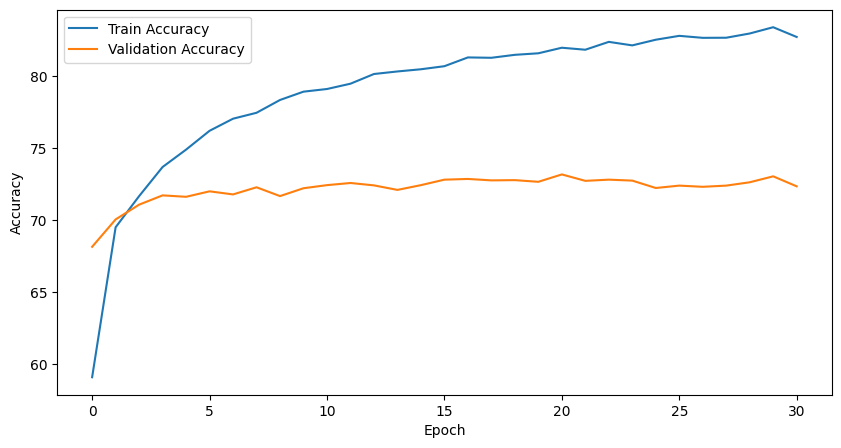

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


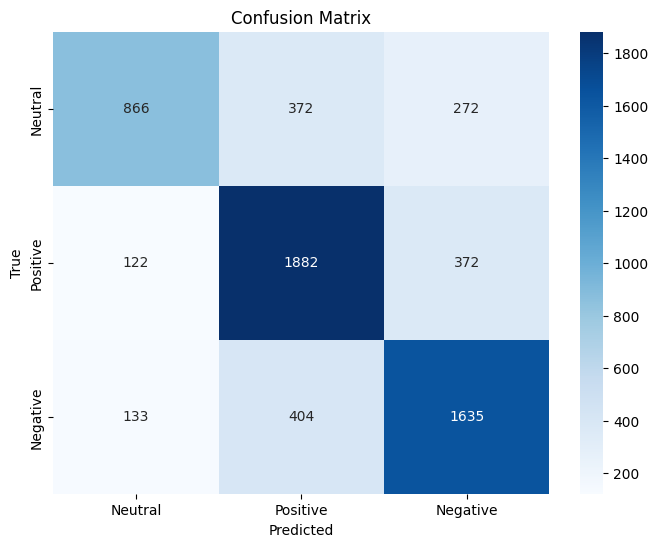


Classification Report:
              precision    recall  f1-score   support

     Neutral       0.77      0.57      0.66      1510
    Positive       0.71      0.79      0.75      2376
    Negative       0.72      0.75      0.73      2172

    accuracy                           0.72      6058
   macro avg       0.73      0.71      0.71      6058
weighted avg       0.73      0.72      0.72      6058



In [37]:
# visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Neutral', 'Positive', 'Negative']))